In [2]:
!pip install --user uproot
import sys
sys.path.append("/home/acraplet/Alie/UROP2021/AnalyserWork/RootFiles")
import uproot 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import matplotlib as mpl
%matplotlib inline
#mpl.use('TkAgg')~

import matplotlib.pyplot as plt

#### This script was used to analyse data produced by the CMS detector at CERN. In this experiement, the focus was on the H->ττ decay chain. This channel is used to probe the CP state of the Higgs boson, see the following paper for more information: https://cds.cern.ch/record/2725571?ln=en

#### The analysis resolves around finding variables that are sensitive to the CP state of the Higgs boson, these variables can be low-level (the quantities recorded by our detectors) or high-level (constructed using combinaison of low-level quantities). We aim at finding the one variable with the highest CP-sensitivity that we can then use in a log-likelihood scan to obtain a quantitative value for the Higgs' CP-mixing angle. The idea of this exercise is to use a Neural Net to exctract the CP-information out of the available low- and high-level variables and produce an NN score that is more sensitive to the CP state of the Higgs boson than any variable taken individually. 

#### The datasets that will be used have been simulated and therefore we have access to the 'real' value of the Higgs CP state, stored in form of weights: wt_cp_{sm, ps, mm} where 

- sm => $\alpha_{CP} = 0^{\circ}$ Standard Model-like Higgs boson, purely CP even
- ps => $\alpha_{CP} = 90^{\circ}$ Pseudoscalar Higgs boson, purely CP odd
- mm => $\alpha_{CP} = 45^{\circ}$ Maximal-mixing scelarion, Higgs is maximally CP-violating

#### The τ leptons originating from the Higgs decay are very heavy particle, they therefore decay very fast, the  τ lepton can decay either leptonically (in $\mu$ or e) or hadronically (in either $\rho$, $\pi$ or a1 resonnances). In our case we will focus on the $\rho\rho$ decay channel only because it is the one with the highest Branching Fraction and it is also the most sensitive channel we have. The same methid can be applied to other channels. We use the tau_decay_mode_{1,2} and mva_dm_{1,2} selectors to focus on the corre ct portion of the dataset. 

#### An easy way to verify the CP-sensitivity of a variable is to observe its distribution when the Higgs is CP-even to when it is completely CP-odd, that is similar to what the log-likelihood does when it tries to extract the $\alpha_{CP}$ value. Using the available weights, we can split our dataset into more sm-like and more ps-like portions and your objective will be to obtain a NN score for which the ps and sm distributions are as different as possible. 

#### To do this, we can use two methods. 

#### The first method is to use a categorisation (binary) approach where we use the weights to give to each event either a 0 or a 1 depending on whether it is more sm-like or ps-like. Then we traing the NN to correctly classify each event using the variables at hand. 

#### The second method is a regression (continuous) where we use the value of one of the weights as the target to be regressed using the available information. 





In [3]:
tree = uproot.open("/home/acraplet/Alie/UROP2021/AnalyserWork/RootFiles/GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018_BDTOddEven.root")["ntuple"]
tree2 = uproot.open("/home/acraplet/Alie/UROP2021/AnalyserWork/RootFiles/VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]

In [4]:
# First import the data files used in the training. Here we have two production modes of the Higgs: 
# - Vector Boson Fusion 
# - ggH (gluon-fusion)
# The data is located on the lx02 machines, at these locations
#tree = uproot.open("/vols/cms/ac4317/UROP_2021/CMSSW_10_2_19/src/UserCode/ICHiggsTauTau/Analysis/HiggsTauTauRun2/output/outputTTMT/GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018_BDTOddEven.root")["ntuple"]
#tree2 = uproot.open("/vols/cms/ac4317/UROP_2021/CMSSW_10_2_19/src/UserCode/ICHiggsTauTau/Analysis/HiggsTauTauRun2/output/outputTTMT/VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]

In [5]:
# define what variables are to be read into the dataframe

variables = [  "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", 
                #the weights careful these are generator-level, not to be used in the traing
                "rand",
                #random variable to be used in selections
                "pt_1","pt_2",
                #transverse momentum of each tau
                "met", 
                #absolute missing transverse energy
                "aco_angle_1", "aco_angle_5", "aco_angle_6", #"aco_angle_7",
                #acoplanarity angles, see paper for definition, representing angle between the planes spanned
                #by the decay products of the taus or the Impact Parameter
                "y_1_1", "y_1_2",
                #Y variable, calculated from the tau->rho->pions energies, indicates polarisation of the tau
                "ip_sig_1", "ip_sig_2",
                #significance of the impact parameter [see paper]
                "met_dphi_2", "met_dphi_1",
                #angular difference between the met and the taus
             
                "mva_dm_1","mva_dm_2",
                "tau_decay_mode_1","tau_decay_mode_2",
                "deepTauVsJets_medium_1","deepTauVsJets_medium_2",
                "deepTauVsEle_vvloose_1","deepTauVsEle_vvloose_2",
                "deepTauVsMu_vloose_1","deepTauVsMu_vloose_2",
                "trg_doubletau"
                 #triggers and selectors, not to be used in training
             ]

#check the Root files and the variable_description file for more possible inputs.

#the four-verctors of the pions orgininating from the rho
pi_1 = ["pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1"]
pi_2 = ["pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2"]

pi0_1 = ["pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1"]
pi0_2 = ["pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2"]

pi2_1 = ["pi2_E_1", "pi2_px_1", "pi2_py_1", "pi2_pz_1"]
pi2_2 = ["pi2_E_2", "pi2_px_2", "pi2_py_2", "pi2_pz_2"]

pi3_1 = ["pi3_E_1", "pi3_px_1", "pi3_py_1", "pi3_pz_1"]
pi3_2 = ["pi3_E_2", "pi3_px_2", "pi3_py_2", "pi3_pz_2"]


pis = pi_1 + pi_2 + pi2_1 + pi2_2 + pi3_1 + pi3_2 

#create the datasets
df = tree.pandas.df(variables)# + pis)
df2 = tree2.pandas.df(variables)# + pis)

#Index to track the rho rho events more easily
df['index'] =  np.arange(0, len(df), 1)
df2['index'] =  np.arange(0, len(df2), 1)


In [6]:
#select the rho-rho decay more
df_1 = df[
      (df["tau_decay_mode_1"] == 1) 
    & (df["tau_decay_mode_2"] == 1) 
    & (df["mva_dm_1"] == 1) 
    & (df["mva_dm_2"] == 1)
   
]



df2_1 = df2[
      (df2["tau_decay_mode_1"] == 1) 
    & (df2["tau_decay_mode_2"] == 1) 
    & (df2["mva_dm_1"] == 1) 
    & (df2["mva_dm_2"] == 1)
   
]

df4 = pd.concat([df_1, df2_1])


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import tensorflow as tf

In [8]:
#### below - classification

In [9]:
#define the target: either one for sm or zero for ps

df_ps = df_1[
      (df_1["rand"]<df_1["wt_cp_ps"]/2)
]

df_sm = df_1[
      (df_1["rand"]<df_1["wt_cp_sm"]/2)
]


df2_ps = df2_1[
      (df2_1["rand"]<df2_1["wt_cp_ps"]/2)
]

df2_sm = df2_1[
      (df2_1["rand"]<df2_1["wt_cp_sm"]/2)
]


y_sm = pd.DataFrame(np.ones(df_sm.shape[0]))
y_ps = pd.DataFrame(np.zeros(df_ps.shape[0]))

y2_sm = pd.DataFrame(np.ones(df2_sm.shape[0]))
y2_ps = pd.DataFrame(np.zeros(df2_ps.shape[0]))

y = pd.concat([y_sm, y_ps,y2_sm, y2_ps])


In [11]:
#we use the combinaition of the two files 
X = pd.concat([df_sm, df_ps, df2_sm, df2_ps])

# drop any other variables that aren't required in training
X2 = X.drop([
            "wt_cp_sm","wt_cp_ps","wt_cp_mm", "rand",
            "tau_decay_mode_1","tau_decay_mode_2","mva_dm_1","mva_dm_2",
            "deepTauVsJets_medium_1","deepTauVsJets_medium_2",
            "deepTauVsEle_vvloose_1","deepTauVsEle_vvloose_2",
            "deepTauVsMu_vloose_1","deepTauVsMu_vloose_2",
            "trg_doubletau", "index",
           ], axis=1).reset_index(drop=True) 

In [12]:
from sklearn.preprocessing import StandardScaler

#set up your classifier
PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X2)
X_T=PredictorScalerFit.transform(X2)

#split into 80-20% for the traning and testing
X_train, X_test, y_train, y_test = train_test_split(X_T, y, test_size=0.2, random_state=123456)
classifier = tf.keras.Sequential() 

In [13]:
#Set up your NN-structure - carefull this is only an example, by no means optimal

classifier.add(tf.keras.layers.Dense(units=10, input_dim=len(X2.columns), kernel_initializer='uniform', activation='relu'))
classifier.add(tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu'))
classifier.add(tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu'))

classifier.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
#train
survivalANN_Model=classifier.fit(X_train,y_train, batch_size=50 , epochs=50, verbose=1)

Epoch 1/50
6059/6059 [==============================] - 5s 853us/step - loss: 0.6899 - accuracy: 0.5234
Epoch 2/50
6059/6059 [==============================] - 5s 778us/step - loss: 0.6821 - accuracy: 0.5667
Epoch 3/50
6059/6059 [==============================] - 5s 766us/step - loss: 0.6818 - accuracy: 0.5667
Epoch 4/50
6059/6059 [==============================] - 4s 716us/step - loss: 0.6816 - accuracy: 0.5664
Epoch 5/50
6059/6059 [==============================] - 4s 726us/step - loss: 0.6815 - accuracy: 0.5667
Epoch 6/50
6059/6059 [==============================] - 5s 747us/step - loss: 0.6815 - accuracy: 0.5669
Epoch 7/50
6059/6059 [==============================] - 5s 770us/step - loss: 0.6814 - accuracy: 0.5669
Epoch 8/50
6059/6059 [==============================] - 5s 763us/step - loss: 0.6813 - accuracy: 0.5669
Epoch 9/50
6059/6059 [==============================] - 5s 770us/step - loss: 0.6813 - accuracy: 0.5669
Epoch 10/50
6059/6059 [==============================] - 5s 796u

In [19]:
#Using your model, make predictions about the CP-state of the Higgs
Predictions=classifier.predict(X2)

#Add weights to your dataset
X2['NNweights']=Predictions

In [20]:
# Add the weights back to your dataset for plotting
X2['wt_cp_ps']=np.array(X['wt_cp_ps'])
X2['wt_cp_mm']=np.array(X['wt_cp_mm'])
X2['wt_cp_sm']=np.array(X['wt_cp_sm'])

#And add the 'true' cp state
X2['label'] = np.array(y)

Text(0.5, 1.0, 'BDT scores - densities')

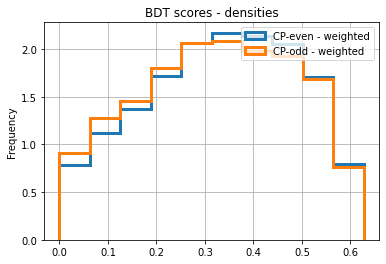

In [22]:
#plot the cp sensitivity of your variable using histograms weighted by the sm and ps weights
nbins = 10
plt.close()
plt.close()
X2["NNweights"].plot(kind="hist", weights=X2["wt_cp_sm"], bins=nbins, histtype=u'step', lw=3,  label='CP-even - weighted', density='True')
X2["NNweights"].plot(kind="hist", weights=X2["wt_cp_ps"], bins=nbins, histtype=u'step', lw=3,  label='CP-odd - weighted', density='True')
leg=plt.legend()
plt.grid()
plt.title("BDT scores - densities")
#plt.savefig('NN_Check_weights')

In [24]:
# Defining the probability threshold
def probThreshold(inpProb):
    if inpProb > 0.5:
        return(1)
    else:
        return(0)
 
# Generating predictions on the testing data by applying probability threshold
X2['binary_prob']=X2['NNweights'].apply(probThreshold)


In [25]:
#Rapid check: what proportion of your dataset is correctly predicted? What did you expect?
check = X2['binary_prob']-X2['label']
check2 = np.where(check==0, 1, 0)
print(1-sum(check2)/len(check2))

0.4968043355394862


In [26]:
# Now the regression method

In [27]:
#Define your input parameters

x = np.array([
              #df["metx"],
              #df["mety"], 
              #df4['wt_cp_sm'],
              df4["aco_angle_1"],  
              df4["aco_angle_5"], 
              df4["aco_angle_6"],  
              df4["y_1_1"], 
              df4["y_1_2"], 
              df4["ip_sig_2"],
              df4["ip_sig_1"],
              #Mom4_to_tf(nu_1.p_x),
              #df4["ip_x_1"], 
              #df4["ip_y_1"], 
              #df4["ip_z_1"],        #leading impact parameter
              #df4["ip_x_2"], 
              #df4["ip_y_2"], 
              #df4["ip_z_2"],
              #df4["met"],  
              df4["met_dphi_1"],
              df4["met_dphi_2"], 
              #sv_z_2
             ])
x = tf.transpose(x)

#and your target, here the sm weight
y = np.array(df4['wt_cp_sm'])

#split your dataset into training and testing 
#note: this is not a uniform sampling of the data, think about what problem it could cause
trainFrac = 0.8
numTrain = int(trainFrac*x.shape[0])
x_train = x[:numTrain]
y_train = y[:numTrain]

x_val = x[numTrain:]
y_val = y[numTrain:]


In [28]:
#Define your NN structure

input_1 = tf.keras.Input(shape = x.shape, name="lab_frame")
#x1 = tf.keras.layers.Dense(32, activation = 'relu', name="learning0")(input_1)
x2 = tf.keras.layers.Dense(32, activation = 'relu', name="learning")(input_1)
x3 = tf.keras.layers.Dense(32, activation = 'relu', name="learning2")(x2)
x4 = tf.keras.layers.Dropout(0.1, name="dropout")(x3)
output = tf.keras.layers.Dense(1, name="output")(x4)

model = tf.keras.Model(
    inputs=[input_1],
    outputs=[output],
)


model.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(loss = loss_fn, optimizer = 'adam', metrics = ['mae'])#, loss_mass_Higgs, loss_mass_tau, loss_D_p])

#run you model
history = model.fit(x, y, validation_split = 0.2,
    epochs=50,
    batch_size = 500)



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lab_frame (InputLayer)       [(None, 382884, 9)]       0         
_________________________________________________________________
learning (Dense)             (None, 382884, 32)        320       
_________________________________________________________________
learning2 (Dense)            (None, 382884, 32)        1056      
_________________________________________________________________
dropout (Dropout)            (None, 382884, 32)        0         
_________________________________________________________________
output (Dense)               (None, 382884, 1)         33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
613/613 [==============================] - 1s 2ms/step - loss: 0.3683 - mae: 0.5032 - val_loss: 0.3063 - va

Epoch 50/50
613/613 [==============================] - 1s 1ms/step - loss: 0.2682 - mae: 0.4320 - val_loss: 0.2732 - val_mae: 0.4363


In [30]:
#make prediction
predictions = model({"lab_frame": x})
pred_vals = []

length = len(predictions)
for i in range(length):
    pred_vals.append(float(predictions[i][0]))
    

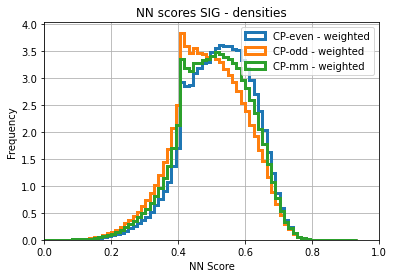

In [34]:
plt.close()

nbins = 10

#here the weights are defined between 0 and 2, we divide by two to have a 0-1 score
pred_vals2 = pd.DataFrame(np.array(pred_vals)/2, columns = ['NNOddEven'])

plt.xlim(0,1)
#can also use the mm weights to check that your variable is smooth, the mm curve should be between the odd and even ones
pred_vals2['NNOddEven'].plot(kind="hist", weights = df4['wt_cp_sm'], bins=nbins, histtype=u'step', lw=3,  label='CP-even - weighted', density='True')
pred_vals2['NNOddEven'].plot(kind="hist", weights = df4['wt_cp_ps'], bins=nbins, histtype=u'step', lw=3,  label='CP-odd - weighted', density='True')
pred_vals2['NNOddEven'].plot(kind="hist", weights = df4['wt_cp_mm'], bins=nbins, histtype=u'step', lw=3,  label='CP-mm - weighted', density='True')

leg=plt.legend()
plt.grid()
plt.title("NN scores SIG - densities")
plt.xlabel('NN Score')
plt.show()
#plt.savefig('ChecksNN_ps_sm_mm')


In [32]:
df4['NNOddEven'] = pred_vals2['NNOddEven']

df_ps = df4[
      (df4["rand"]<df4["wt_cp_ps"]/2)
]

df_sm = df4[
      (df4["rand"]>df4["wt_cp_sm"]/2)
]

df_mm = df4[
      (df4["rand"]<df4["wt_cp_mm"]/2)
]


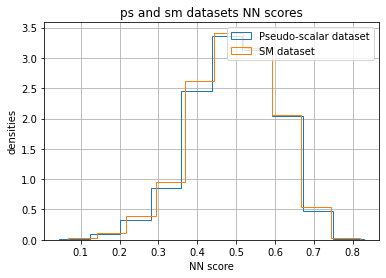

In [33]:
plt.close()
plt.close()
#sanity check, the weighted plot should be similar to the one after you've split your data into ps and sm 
plt.hist(df_ps['NNOddEven'], bins = 10, histtype = 'step', density = True, label = 'Pseudo-scalar dataset')
plt.hist(df_sm['NNOddEven'], bins = 10, histtype = 'step', density = True, label = 'SM dataset')
plt.legend()
plt.title('ps and sm datasets NN scores')
plt.xlabel('NN score')
plt.ylabel('densities')
plt.grid()
plt.show()
#plt.savefig('CheckNN')


In [ ]:
# Next: see the same problem tackled by a BDT